In [1]:
!pip install torch torchvision torchaudio matplotlib pandas scikit-learn --quiet

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import sqlite3

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query energy data
energy_data = {
    'solar': pd.read_sql_query("SELECT datetime, value FROM SUN_data_NE", conn),
    'wind': pd.read_sql_query("SELECT datetime, value FROM WND_data_NE", conn),
    'demand': pd.read_sql_query("SELECT datetime, Demand as value FROM demand_data_NE", conn)
}

conn.close()

In [4]:
# Rename and convert time columns
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
for source in energy_data:
    energy_data[source]['datetime'] = pd.to_datetime(energy_data[source]['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)

# Scale weather features
scaler = MinMaxScaler()
scaled_weather = scaler.fit_transform(weather_data[['temperature', 'dwpt', 'humidity',
                                                    'precipitation', 'wdir', 'windspeed',
                                                    'pres', 'cloudcover', 'hour', 'month']])

# Scale energy data
energy_scalers = {}
for source, data in energy_data.items():
    energy_scalers[source] = MinMaxScaler()
    energy_data[source]['value'] = energy_scalers[source].fit_transform(data[['value']])

In [5]:
class EnergyDataset(Dataset):
    def __init__(self, weather_data, energy_data, sequence_length):
        self.weather_data = weather_data
        self.energy_data = energy_data
        self.sequence_length = sequence_length
        self.length = len(weather_data) - sequence_length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = torch.tensor(self.weather_data[idx:idx+self.sequence_length], dtype=torch.float32)
        y = {
            source: torch.tensor(self.energy_data[source]['value'][idx+self.sequence_length], dtype=torch.float32)
            for source in self.energy_data
        }
        return x, y

In [6]:
class EnergyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EnergyRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [7]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = {k: v.to(device) for k, v in y_batch.items()}

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = sum(criterion(outputs[:, i], y_batch[source]) for i, source in enumerate(y_batch))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return losses

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = {source: [] for source in energy_data}
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch).cpu().numpy()
            predictions.append(outputs)
            for source in y_batch:
                actuals[source].append(y_batch[source].cpu().numpy())
    return np.concatenate(predictions), {source: np.concatenate(values) for source, values in actuals.items()}

In [9]:
# Hyperparameters
sequence_length = 24
batch_size = 32
hidden_size = 128
num_epochs = 20
learning_rate = 0.001
output_size = len(energy_data)

# Create dataset and data loaders
dataset = EnergyDataset(scaled_weather, energy_data, sequence_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyRNN(input_size=scaled_weather.shape[1], hidden_size=hidden_size, output_size=output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Epoch 1/20, Loss: 0.0724
Epoch 2/20, Loss: 0.0415
Epoch 3/20, Loss: 0.0372
Epoch 4/20, Loss: 0.0341
Epoch 5/20, Loss: 0.0328
Epoch 6/20, Loss: 0.0310
Epoch 7/20, Loss: 0.0305
Epoch 8/20, Loss: 0.0295
Epoch 9/20, Loss: 0.0288
Epoch 10/20, Loss: 0.0277
Epoch 11/20, Loss: 0.0272
Epoch 12/20, Loss: 0.0264
Epoch 13/20, Loss: 0.0255
Epoch 14/20, Loss: 0.0249
Epoch 15/20, Loss: 0.0240
Epoch 16/20, Loss: 0.0235
Epoch 17/20, Loss: 0.0228
Epoch 18/20, Loss: 0.0218
Epoch 19/20, Loss: 0.0214
Epoch 20/20, Loss: 0.0203


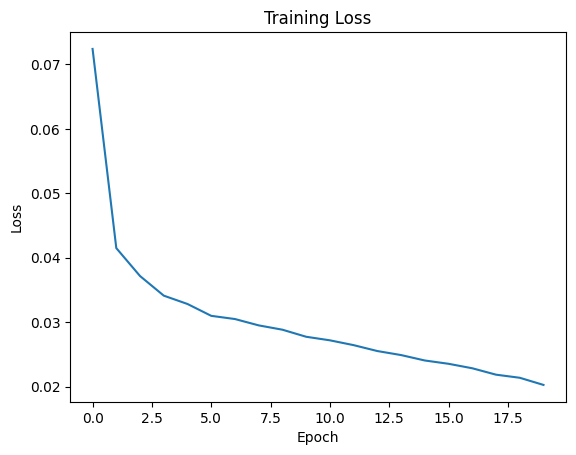

In [10]:
# Train the model
losses = train_model(model, train_loader, optimizer, criterion, num_epochs)

# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Inverse transform predictions and actuals
predictions_inverse = energy_scalers['solar'].inverse_transform(predictions[:, [0]])
actuals_inverse = energy_scalers['solar'].inverse_transform(actuals['solar'].reshape(-1, 1))

# Metrics
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

Mean Absolute Error (MAE): 37.7404
Root Mean Square Error (RMSE): 62.1492
R-squared (R^2): 0.8848


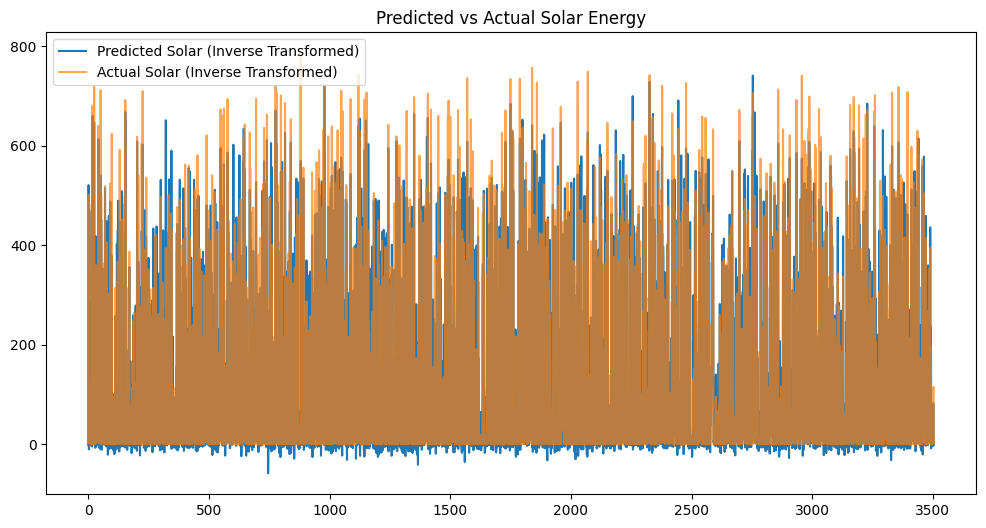

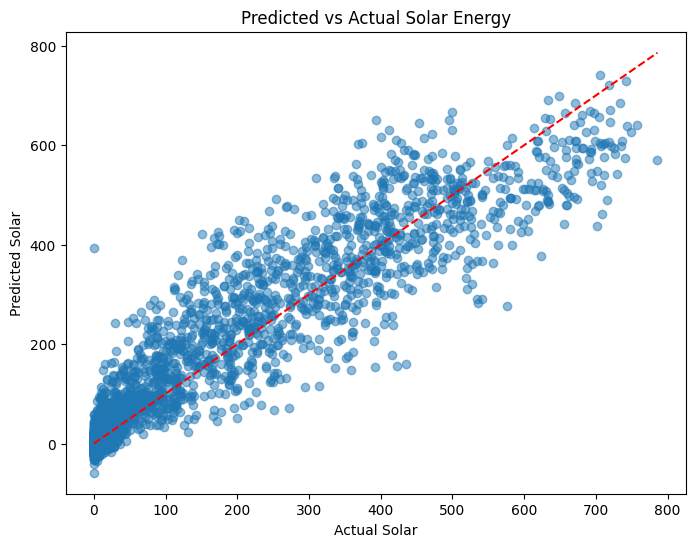

In [13]:
# Visualize predictions vs actuals for solar energy
plt.figure(figsize=(12, 6))
plt.plot(predictions_inverse, label="Predicted Solar (Inverse Transformed)")
plt.plot(actuals_inverse, label="Actual Solar (Inverse Transformed)", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Solar Energy")
plt.show()

# Scatter plot for predicted vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(actuals_inverse, predictions_inverse, alpha=0.5)
plt.title("Predicted vs Actual Solar Energy")
plt.xlabel("Actual Solar")
plt.ylabel("Predicted Solar")
plt.plot([0, np.max(actuals_inverse)], [0, np.max(actuals_inverse)], color="red", linestyle="--")  # Reference diagonal
plt.show()